<a href="https://colab.research.google.com/github/ekandikattu/CS4372/blob/main/Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Linear Regression Assignment**

---





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm

Pre-Processing

---



Load Dataset

In [ ]:
# read csv into dataframe
df = pd.read_csv('https://raw.githubusercontent.com/ekandikattu/CS4372/refs/heads/main/Linear_Regression/winequality-white.csv', sep=';')

In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,3.19,0.40,9.9,6
4,6.2,0.32,0.16,7.0,0.045,30.0,3.18,0.47,9.6,6


In [ ]:
df.shape

(4898, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [ ]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


Check for Data Consistency

In [ ]:
# no missing or null values
df.isna().sum()

,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
# since we have 937 rows of duplicate data (around 20% of the total dataset size), we remove the duplicates to avoid biasing the model
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

np.int64(0)

In [ ]:
# new df dimensions
df.shape

(3961, 12)

Examining Attributes (Physiochemical Qualities) vs Target (Wine Quality)

In [ ]:
# Attributes
attributes = df.columns[:-1]
attributes

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [ ]:
# Target
target = df.columns[-1]
target

'quality'

In [ ]:
# class distribution of quality
df[target].value_counts()

,count
quality,
6,1788
5,1175
7,689
4,153
8,131
3,20
9,5


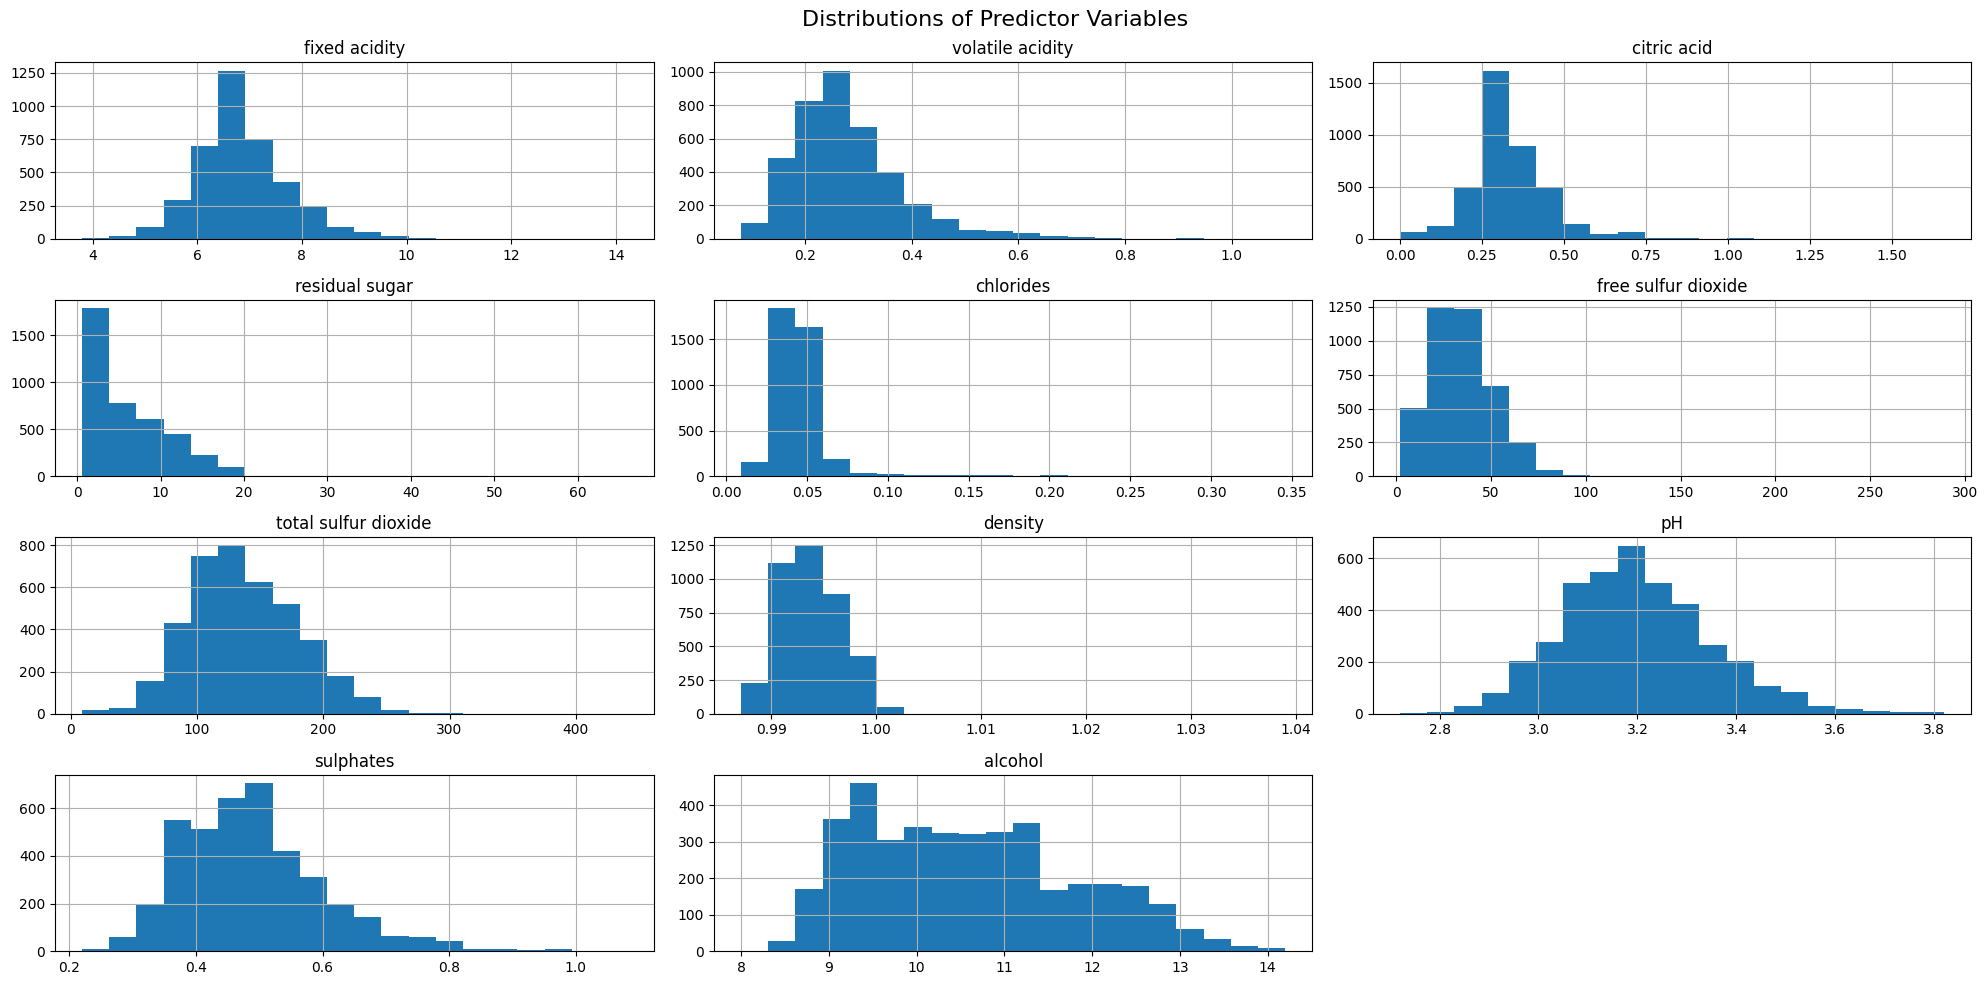

In [ ]:
# Check the distribution of each attribute/feature
df[attributes].hist(bins=20, figsize=(20,10))
plt.suptitle("Distributions of Predictor Variables", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# All predictors are numerical (no need to convert).
# Normal-like Distributions: fixed acidity, citric acid, total sulfur dioxide, pH, and alcohol look somewhat bell-shaped like a normal distribution
# Skewed Distributions: volatile acidity, residual sugar, chlorides, free sulfur dioxide, sulphates, density have right-skew

In [ ]:
# Possible Explanations for non-normal distributions:
# Common in chemical compositions to have many samples near zero/low values (bounded by zero) and some extreme values creating skew

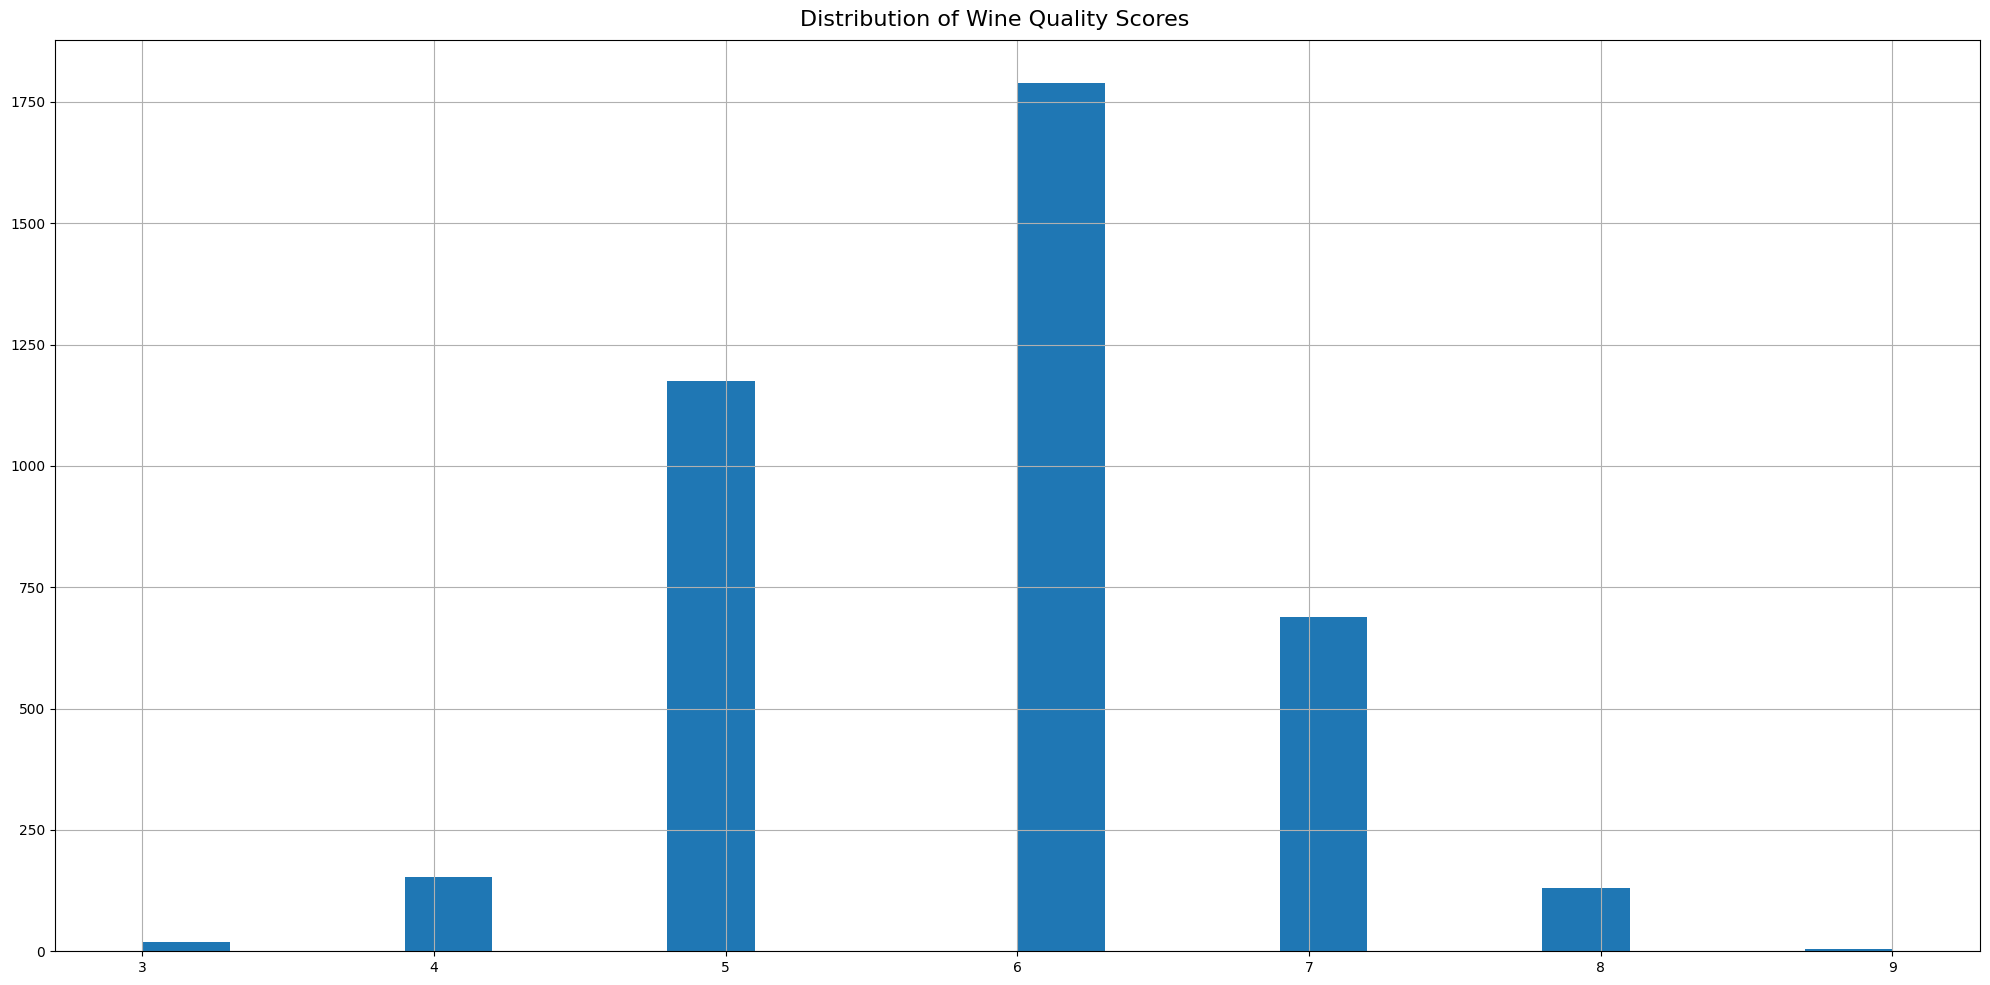

In [ ]:
# Check distribution of the target
df[target].hist(bins=20, figsize=(20,10))
plt.suptitle("Distribution of Wine Quality Scores", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Wine quality falls in a range of (3-9), but most are (5-7). There is clear class imbalance, with the target skewed towards average scores (with class 6 being the most frequent)

Standardize and Normalize Attributes

In [ ]:
# Considering that all the features are continuous chemical measurements, normalization is not necessary
# Standardization is necessary because SGD Regressor is scale-sensitive (gradient-based)

Correlation of Physiochemical Properties and Wine Quality

In [ ]:
# create a correlation matrix for the features and the target variables
corr_matrix = df.corr()
corr_matrix

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.019214,0.298959,0.083620,0.024036,-0.058396,0.082425,0.266091,-0.431274,-0.017453,-0.110788,-0.124636
volatile acidity,-0.019214,1.000000,-0.163228,0.098340,0.086287,-0.102471,0.102315,0.060603,-0.046954,-0.021150,0.046815,-0.190678
citric acid,0.298959,-0.163228,1.000000,0.106269,0.132590,0.091681,0.122845,0.160076,-0.183015,0.049442,-0.076514,0.007065
residual sugar,0.083620,0.098340,0.106269,1.000000,0.076091,0.306835,0.409583,0.820498,-0.165997,-0.020503,-0.398167,-0.117339
chlorides,0.024036,0.086287,0.132590,0.076091,1.000000,0.101272,0.191145,0.253088,-0.090573,0.017871,-0.356928,-0.217739
free sulfur dioxide,-0.058396,-0.102471,0.091681,0.306835,0.101272,1.000000,0.619437,0.294638,-0.007750,0.037932,-0.251768,0.010507
total sulfur dioxide,0.082425,0.102315,0.122845,0.409583,0.191145,0.619437,1.000000,0.536868,0.008239,0.136544,-0.446643,-0.183356
density,0.266091,0.060603,0.160076,0.820498,0.253088,0.294638,0.536868,1.000000,-0.063734,0.082048,-0.760162,-0.337805
pH,-0.431274,-0.046954,-0.183015,-0.165997,-0.090573,-0.007750,0.008239,-0.063734,1.000000,0.142353,0.093095,0.123829
sulphates,-0.017453,-0.021150,0.049442,-0.020503,0.017871,0.037932,0.136544,0.082048,0.142353,1.000000,-0.022850,0.053200


<function matplotlib.pyplot.show(close=None, block=None)>

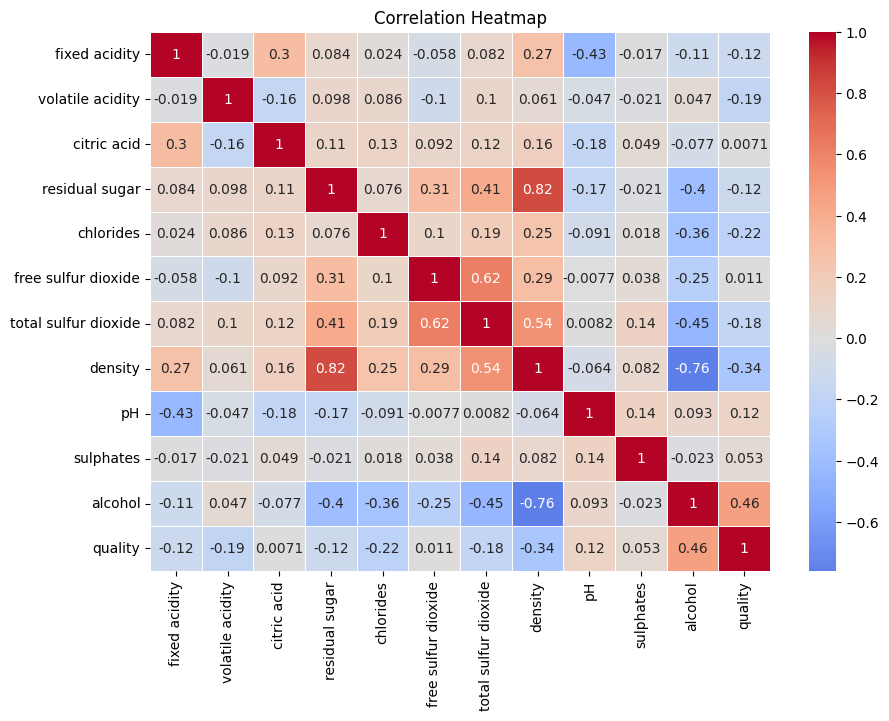

In [ ]:
# create a heatmap of correlations
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show

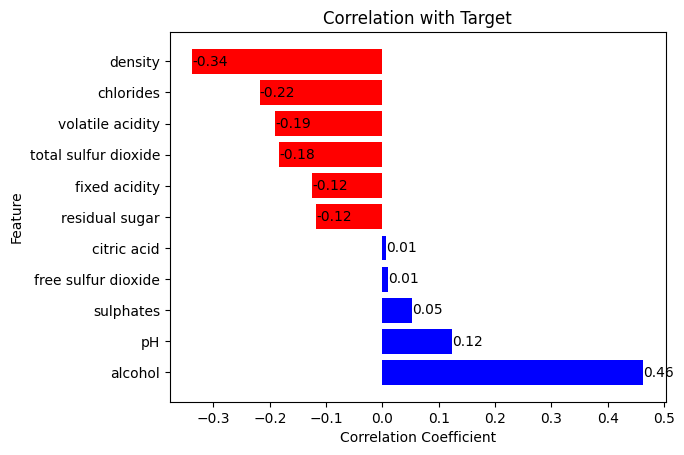

In [ ]:
 # create a bar chart of correlation values with target (descending order)
importance = corr_matrix[target].sort_values(ascending=False)[1:]
colors = ['red' if val < 0 else 'blue' for val in importance]
plt.barh(importance.index, importance.values, color=colors)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.title('Correlation with Target')
# add value labels
for i, val in enumerate(importance.values):
    plt.text(val, i, f'{val:.2f}', ha='left', va='center')

plt.show()

In [ ]:
# Since residual sugar - density have a collinearity of 0.82 and density - alcohol have a collinearity of -0.76 (where alcohol is the strongest predictor of target with 0.46),
# we drop density
# we drop total sulfur dioxide as well, as it is inter-correlated with free sulfur dioxide, which has a positive correlation with quality.
# drop density and total sulfur dioxide from features
df = df.drop(['density', 'total sulfur dioxide'], axis=1)
attributes = df.columns[:-1]
target = df.columns[-1]
df


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,3.19,0.40,9.9,6
4,6.2,0.32,0.16,7.0,0.045,30.0,3.18,0.47,9.6,6
...,...,...,...,...,...,...,...,...,...,...
3956,6.2,0.21,0.29,1.6,0.039,24.0,3.27,0.50,11.2,6
3957,6.6,0.32,0.36,8.0,0.047,57.0,3.15,0.46,9.6,5
3958,6.5,0.24,0.19,1.2,0.041,30.0,2.99,0.46,9.4,6
3959,5.5,0.29,0.30,1.1,0.022,20.0,3.34,0.38,12.8,7


Testing/Training Split (80/20)

In [ ]:
X = df[attributes].copy()
y = df[target].copy()

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (3168, 9) (3168,)
Test shape: (793, 9) (793,)


In [166]:
def metrics(y_true, y_pred, label=""):
  r2 = r2_score(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  print(f"{label} Metrics: R2={r2:.4f} | RMSE={rmse:.3f} | MAE={mae:.3f}")
  return r2, rmse, mae

Model Construction

---



SGD Regressor

In [ ]:
sgd_pipe = Pipeline([
    ('std_scaler', StandardScaler()),
    ("sgd", SGDRegressor(random_state=42))
])

In [ ]:
# all parameters for SGD
sgd = SGDRegressor()
sorted(sgd.get_params().keys())

['alpha',
 'average',
 'early_stopping',
 'epsilon',
 'eta0',
 'fit_intercept',
 'l1_ratio',
 'learning_rate',
 'loss',
 'max_iter',
 'n_iter_no_change',
 'penalty',
 'power_t',
 'random_state',
 'shuffle',
 'tol',
 'validation_fraction',
 'verbose',
 'warm_start']

In [ ]:
# create parameter distributions for every parameter in sgd
param_distributions = {
    "sgd__loss": ["squared_error", "huber", "epsilon_insensitive", "squared_epsilon_insensitive"],
    "sgd__penalty": ["l2", "l1", "elasticnet", None],
    "sgd__alpha": np.logspace(-6, -1, 12),
    "sgd__l1_ratio": [0.15, 0.3, 0.5, 0.7, 0.9],
    "sgd__fit_intercept": [True],
    "sgd__max_iter": [1000, 3000, 8000],
    "sgd__tol": [0.001, 0.0001, 0.00001],
    "sgd__shuffle": [True],
    # "sgd__verbose": [0], # verbosity is handled by RandomizedSearchCV
    "sgd__epsilon": [0.01, 0.05, 0.1, 0.2],
    # "sgd__random_state": [42], # random_state is set in the pipeline
    "sgd__learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
    "sgd__eta0": [0.0005, 0.001, 0.005, 0.01, 0.05],
    "sgd__power_t": [0.25, 0.5, 0.75],
    "sgd__early_stopping": [True],
    # "sgd__validation_fraction": [0.1, 0.2], # Removed as it's not a valid parameter when early_stopping is True
    "sgd__n_iter_no_change": [5, 10, 15],
    # "sgd__warm_start": [False], # Removed as it's not a valid parameter for SGDRegressor in a pipeline
    "sgd__average": [True, False],
}

In [ ]:
# do K-fold Cross Validation and search for best values for hyperparameters
cv = KFold(n_splits=5, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    sgd_pipe,
    param_distributions=param_distributions,
    n_iter=60,
    scoring="r2",
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                             ('sgd',
                                              SGDRegressor(random_state=42))]),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'sgd__alpha': array([1.00000000e-06, 2.84803587e-06, 8.11130831e-06, 2.31012970e-05,
       6.57933225e-05, 1.87381742e-04, 5.33669923e-04, 1.51991108e-03,
       4....
                                                               'invscaling',
                                                               'adaptive'],
                                        'sgd__loss': ['squared_error', 'huber',
                                                      'epsilon_insensitive',
                                                      'squared_epsilon_insensitive'],
                                        'sgd__max_iter': [1000, 3000, 8000],
                                        'sgd__n_iter_no_change': [5, 10, 15],
                                        'sgd__penalty': ['l2', 'l1',
                                                         'elasticnet', None],
                                        'sgd__power_t': [0.25, 0.5, 0.75],
                                        'sgd__shuffle': [True],
                                        'sgd__tol': [0.001, 0.0001, 1e-05]},
                   random_state=42, scoring='r2', verbose=1)

In [ ]:
# store best hyperparameter values
best_sgd = search.best_estimator_
print("Best SGD Parameters: ", search.best_params_)

Best SGD Parameters:  {'sgd__tol': 1e-05, 'sgd__shuffle': True, 'sgd__power_t': 0.25, 'sgd__penalty': 'l1', 'sgd__n_iter_no_change': 5, 'sgd__max_iter': 1000, 'sgd__loss': 'squared_error', 'sgd__learning_rate': 'adaptive', 'sgd__l1_ratio': 0.15, 'sgd__fit_intercept': True, 'sgd__eta0': 0.005, 'sgd__epsilon': 0.01, 'sgd__early_stopping': True, 'sgd__average': False, 'sgd__alpha': np.float64(6.579332246575683e-05)}


In [167]:
y_train_pred = best_sgd.predict(X_train)
y_test_pred = best_sgd.predict(X_test)
sgd_train = metrics(y_train, y_train_pred, "Train")
sgd_test = metrics(y_test, y_test_pred, "Test")

Train Metrics: R2=0.3014 | RMSE=0.549 | MAE=0.575
Test Metrics: R2=0.2397 | RMSE=0.624 | MAE=0.605


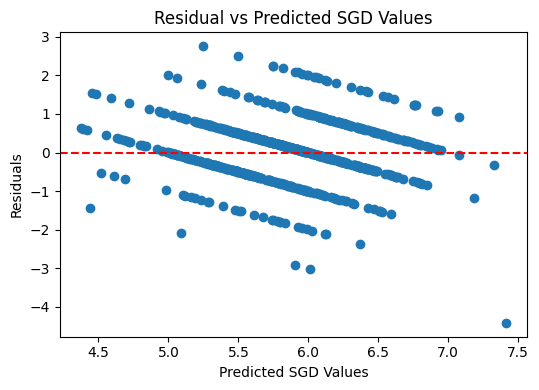

In [ ]:
# Residual Plot
residuals = y_test - y_test_pred
plt.figure(figsize=(5.5, 4))
plt.scatter(y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted SGD Values')
plt.ylabel('Residuals')
plt.title('Residual vs Predicted SGD Values')
plt.tight_layout()
plt.show()

In [ ]:
# experiment log (all CV trials + final test metrics)
import time, json
cv_df = pd.DataFrame(search.cv_results_)
params_df = cv_df["params"].apply(pd.Series)
log_df = pd.concat([params_df, cv_df[["mean_test_score", "std_test_score", "rank_test_score"]]], axis=1).sort_values("rank_test_score")
summary_row = {
    **search.best_params_,
    "mean_test_score": search.best_score_,
    "std_test_score": cv_df.loc[cv_df["rank_test_score"]==1, "std_test_score"].iloc[0],
    "rank_test_score": 1,
    "heldout_R2": sgd_test[0],
    "heldout_RMSE": sgd_test[1],
    "heldout_MAE": sgd_test[2],
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "features": json.dumps(list(X_train.columns))
}
log_df = pd.concat([log_df, pd.DataFrame([summary_row])], ignore_index=True)
log_df

,sgd__tol,sgd__shuffle,sgd__power_t,sgd__penalty,sgd__n_iter_no_change,sgd__max_iter,sgd__loss,sgd__learning_rate,sgd__l1_ratio,sgd__fit_intercept,...,sgd__average,sgd__alpha,mean_test_score,std_test_score,rank_test_score,heldout_R2,heldout_RMSE,heldout_MAE,timestamp,features
0,0.00001,True,0.25,l1,5,1000,squared_error,adaptive,0.15,True,...,False,0.000066,2.941231e-01,2.977244e-02,1,NaN,NaN,NaN,NaN,NaN
1,0.00001,True,0.50,l2,5,1000,squared_epsilon_insensitive,adaptive,0.15,True,...,False,0.000066,2.939210e-01,2.955090e-02,2,NaN,NaN,NaN,NaN,NaN
2,0.00100,True,0.50,l2,5,1000,squared_epsilon_insensitive,adaptive,0.90,True,...,False,0.035112,2.938571e-01,2.849144e-02,3,NaN,NaN,NaN,NaN,NaN
3,0.00010,True,0.50,elasticnet,15,8000,squared_epsilon_insensitive,adaptive,0.30,True,...,False,0.000003,2.936107e-01,2.961437e-02,4,NaN,NaN,NaN,NaN,NaN
4,0.00010,True,0.50,l1,15,3000,squared_epsilon_insensitive,adaptive,0.50,True,...,False,0.000066,2.935110e-01,2.960864e-02,5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.00001,True,0.50,elasticnet,5,1000,squared_epsilon_insensitive,optimal,0.70,True,...,True,0.100000,-3.626303e+18,1.822155e+18,57,NaN,NaN,NaN,NaN,NaN
57,0.00001,True,0.25,l2,10,1000,squared_error,optimal,0.90,True,...,True,0.035112,-1.061708e+19,1.126666e+19,58,NaN,NaN,NaN,NaN,NaN
58,0.00010,True,0.50,l1,10,3000,squared_epsilon_insensitive,optimal,0.50,True,...,True,0.012328,-9.195098e+19,8.948495e+19,59,NaN,NaN,NaN,NaN,NaN
59,0.00001,True,0.75,l2,5,1000,squared_epsilon_insensitive,optimal,0.70,True,...,True,0.000008,-3.824175e+24,1.742256e+24,60,NaN,NaN,NaN,NaN,NaN


Ordinary Linear Regression (OLS)

In [ ]:
ols_scaler = StandardScaler().fit(X_train)
X_train_std = ols_scaler.transform(X_train)
X_test_std = ols_scaler.transform(X_test)

X_train_sm = sm.add_constant(X_train_std)
X_test_sm = sm.add_constant(X_test_std)

ols = sm.OLS(y_train, X_train_sm).fit()
print(ols.summary()) # model summary for report

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     151.4
Date:                Mon, 22 Sep 2025   Prob (F-statistic):          1.89e-238
Time:                        03:19:35   Log-Likelihood:                -3546.1
No. Observations:                3168   AIC:                             7112.
Df Residuals:                    3158   BIC:                             7173.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8513      0.013    443.686      0.0

In [168]:
# predicted values
y_train_pred_ols = ols.predict(X_train_sm)
y_test_pred_ols = ols.predict(X_test_sm)
ols_train = metrics(y_train, y_train_pred_ols, "Train")
ols_test = metrics(y_test, y_test_pred_ols, "Test")

Train Metrics: R2=0.3015 | RMSE=0.549 | MAE=0.575
Test Metrics: R2=0.2389 | RMSE=0.624 | MAE=0.605


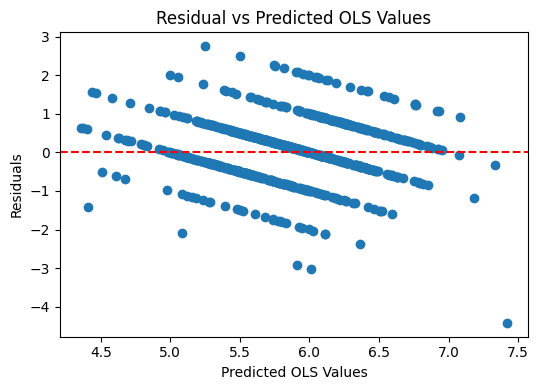

In [ ]:
residuals_ols = y_test - y_test_pred_ols
plt.figure(figsize=(5.5, 4))
plt.scatter(y_test_pred_ols, residuals_ols)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted OLS Values')
plt.ylabel('Residuals')
plt.title('Residual vs Predicted OLS Values')
plt.tight_layout()
plt.show()